## SIMULATOR AND SUMMARY STATISTICS

In [1]:
import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
sys.path.append("./../..")

In [2]:
# Load the minimum required library to run the functions
#from Utils_functions import *
from InternalLibrary.StatisticalFunctions import *
from InternalLibrary.SimulatorPackage import Simulator_noGPU

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from tqdm import tqdm
import _pickle as pickle


2024-05-29 09:18:26.886454: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 09:18:27.584514: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
dt = 1e-6# The time step size for the simulation. This is the amount of time that passes in the model for each step of the simulation
Sample_frequency = 25_000 # The sampling frequency. This is the number of samples that are recorded per unit time
DeltaT = 1/Sample_frequency # The sampling period. This is the amount of time that passes in the model between each sample that is recorded
TotalT = 13 # The total time for the simulation. This is the total amount of time that the simulation is intended to represent
transient = 3
t_corr = TotalT/50

# n_sim = int(10)


In [6]:
time_steps_amount = np.int64((TotalT-transient)/dt) # Number of steps
sampled_point_amount = np.int64((TotalT-transient)/DeltaT) # Number of sampled points
sampling_delta_time_steps = np.int64(DeltaT/dt) # Number of steps between samples
t = np.linspace(0., TotalT - transient, sampled_point_amount) # Time array

In [7]:
# Limits for the parameters (kbT=3.8 pN nm)
prior_limits = {
    "mu_y": [1e4, 140e4],
    "k_y": [1.5e-2, 30e-2],
    "k_int": [1e-3, 6e-3],
    "tau": [2e-2, 20e-2],
    "eps": [0.5, 6],
}

In [8]:
tnice = [DeltaT for t in range(sampled_point_amount - 1)]

In [9]:
# Dummy call to compile the simulator
theta, theta_torch = get_theta_from_prior(prior_limits, 1)
Simulator_noGPU(0.1, 0.1, 0.5, theta);

### If you want to compute simulations

In [10]:
n_sim = int(100)

In [11]:
theta, theta_torch = get_theta_from_prior(prior_limits, n_sim)
x_trace, y_trace, f_trace = Simulator_noGPU(dt, DeltaT, TotalT, theta, transient_time = transient)

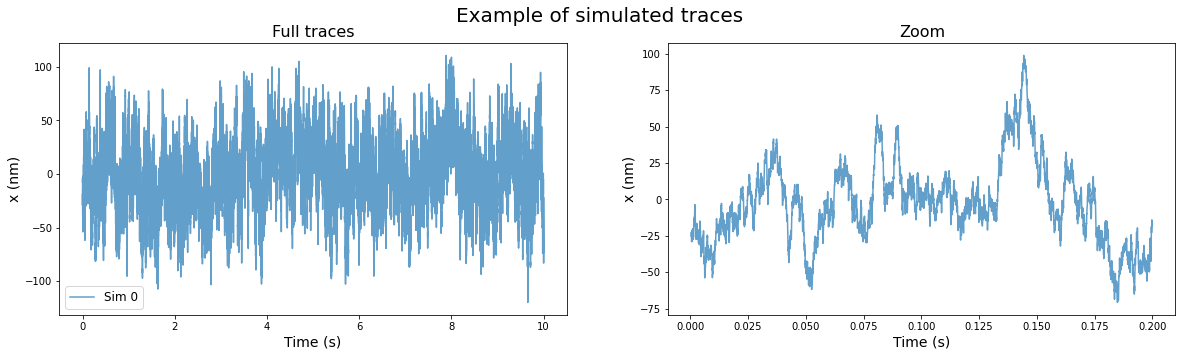

In [10]:
# Example of simulated traces
plt.figure(figsize=(20, 5))
plt.suptitle("Example of simulated traces", fontsize=20)

plt.subplot(121)
for i in range(min([n_sim, 5])):
    plt.plot(t, x_trace[i], label=f"Sim {i}", alpha=0.7)
plt.title("Full traces", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("x (nm)", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
for i in range(min([n_sim, 5])):
    plt.plot(t[10:5000], x_trace[i, 10:5000], label=f"Sim {i}", alpha=0.7)
plt.title("Zoom", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("x (nm)", fontsize=14);


In [12]:
# Compute the summary statistics from the simulations 
first = True
statsss = [["Cxx"], ["Cxx_cl_lin"], ["Cxx_cl_log"], ["s_red1"], ["s_red2"], ["s_redx"], ["s_redx_cl_lin"],
           ["s_redx_cl_log"], ["psdx"], ["tucci"]]
indeces = []
s_i = np.array([])
for i in range(n_sim):
    print("i = ", i+1, " / ", i+1, end="\r")  
    summary_stats = compute_summary_statistics(x_trace[i], theta[:,i])
    s_i = np.append(s_i, select_summary_statistics(summary_stats, np.array(statsss).flatten()))
    if first:
        Size = select_summary_statistics(summary_stats, np.array(statsss).flatten()).size(1)
        first = False
        for cosa in statsss:
            indeces.append(select_summary_statistics(summary_stats, cosa).shape[1])
    """
    if first:
        s_tot = s_i
        theta_tot = torch.from_numpy(summary_stats["theta"]).to(torch.float32)
        summary_stats_length = [len(summary_stats[s]) for s in selected_stats]
        print("Length of each summary statistics: ", summary_stats_length)
        first = False
    else:
        s_tot = torch.cat((s_tot, s_i), dim=0)
        theta_tot = torch.cat((theta_tot, torch.from_numpy(summary_stats["theta"]).to(torch.float32)), dim=1)"""

#print("s_tot shape: ", s_tot.shape, ",  theta_tot shape: ", theta_tot.shape)

In [52]:
print(indeces)

[12499]


In [13]:
s_i = s_i.reshape(n_sim, Size)


In [28]:
#print("mean", np.mean(s_i,axis=0))
#print("std", np.std(s_i,axis=0))
print("ratio", np.divide(np.std(s_i,axis=0), np.mean(s_i,axis=0)))

mean [1467.44337952 1463.21972778 1459.01952148 ... -447.90822266  -98.90258413
  212.9387252 ]
ratio [  2.57482471   2.58224175   2.5896531  ... -14.88156799 -12.0125172
   5.58022383]


In [14]:
ratios = np.divide(np.std(s_i,axis=0), np.mean(s_i,axis=0))
indecents = np.cumsum(indeces)
print(ratios)

[  2.57482471   2.58224175   2.5896531  ... -14.88156799 -12.0125172
   5.58022383]


(-2.0, 10.5)

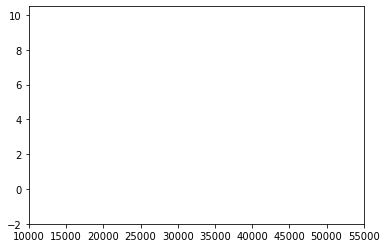

In [30]:
i=0
plt.plot(ratios[indecents[i]:indecents[i+1]])
#for i, vline in enumerate(indecents):
  #  plt.axvline(vline)#, ylabel=statsss[i][0])
    
#plt.legend(
plt.xlim(10000,55000)
plt.ylim(-2,10.5)

In [25]:
soglia = 0.5
mask = np.abs(ratios) < soglia

In [17]:
dictionary = {
    "ratios": ratios,
    "statistics": statssssss,
    "indeces": indecents,
    "mask": mask,
}



NameError: name 'statssssss' is not defined

### Visualization and normalization of $\theta$

In [47]:
print(s_tot[0,:])

tensor([ 1.0090e-01,  1.6646e-03, -6.4932e-04, -2.4834e-04,  4.2231e-04,
        -1.2392e-04,  6.3665e-05])


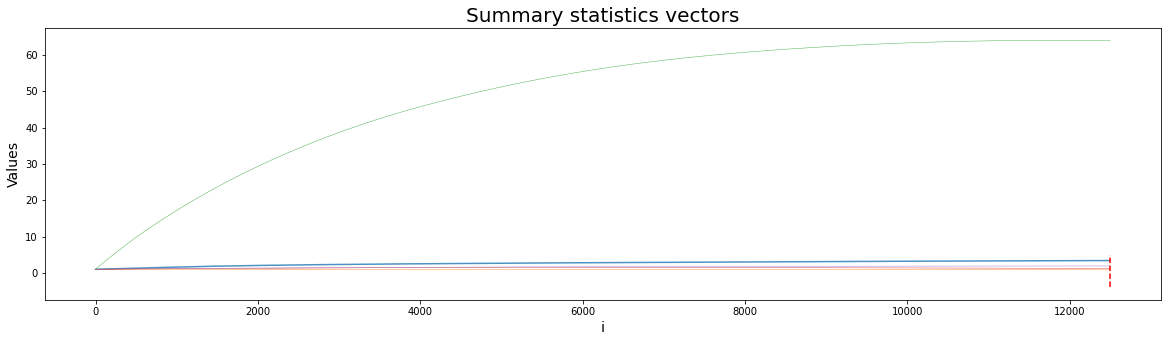

In [45]:
plt.figure(figsize=(20, 5))
plt.title("Summary statistics vectors", fontsize=20)
plt.xlabel("i", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.plot(s_tot[0, :], alpha=0.8)

for i in range(1, min([s_tot.shape[0], 20])):
    plt.plot(s_tot[i, :], lw=0.5, alpha=0.8)

plt.vlines(x=np.cumsum(summary_stats_length)-1, ymin=-4, ymax=5, color='r', linestyles='dashed');

In [19]:
# Rescale the parameters in [-0.5, 0.5]
theta_tot_norm = rescale_theta(theta_tot, prior_limits)

NameError: name 'rescale_theta' is not defined

## INFERENCE

Additional things to try:
* Combinatorial game out of the summary statistics
* Other SNPE methods (https://sbi-dev.github.io/sbi/tutorial/16_implemented_methods/)
* Multi-round training (defining a priori the observation)?

In [11]:
from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, SNPE_A, SNPE_C, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

In [12]:
# Prior distribution for sbi
prior_box = get_prior_box(prior_limits)

## Prior box if theta normalized:
prior_box = utils.torchutils.BoxUniform(low=torch.tensor([-0.5]*len(prior_limits)), high=torch.tensor([0.5]*len(prior_limits)))

prior, num_parameters, prior_returns_numpy = process_prior(prior_box)

In [20]:
# Call infer form sbi
infer = SNPE(prior=prior)
inferece = infer.append_simulations(theta_tot, s_tot)

In [21]:
# Train the model
density_estimator = infer.train(num_atoms=20, show_train_summary=True, 
                                training_batch_size=500, learning_rate=0.005) 
posterior = infer.build_posterior(density_estimator)

 Neural network successfully converged after 37 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 37
        Best validation performance: -65.8696
        -------------------------
        


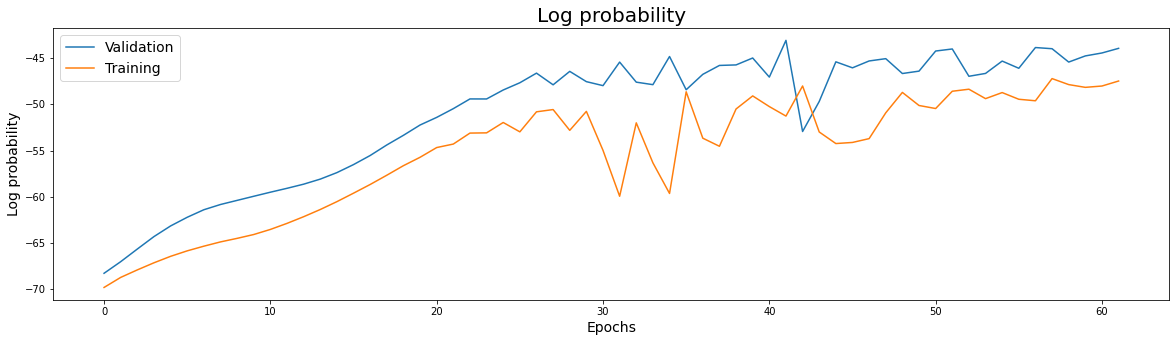

In [19]:
plt.figure(figsize=(20, 5))
plt.title("Log probability", fontsize=20)
plt.plot(infer.summary["validation_log_probs"], label="Validation")
plt.plot(infer.summary["training_log_probs"], label="Training")
plt.legend(fontsize=14)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Log probability", fontsize=14);

In [100]:
# with open("posterior_normalized_theta.pkl", "wb") as f:
#     pickle.dump(posterior, f)

In [101]:
# with open("posterior_normalized_theta.pkl", "rb") as f:
#     posterior = pickle.load(f)

In [ ]:
# Get the observed trace
theta_true, theta_torch_true = get_theta_from_prior(prior_limits, 1)
x_trace_true, y_trace_true, f_trace_true = Simulator_noGPU(dt, DeltaT, TotalT, theta_true, transient_time=transient)
print("theta_true.shape: ", theta_true.shape)
print("x_trace_true.shape: ", x_trace_true.shape)

theta_true.shape:  (5, 1, 1)
x_trace_true.shape:  (1, 249999)


In [23]:
# Compute the summary statistics for the observed trace
summary_stats_true = compute_summary_statistics(x_trace_true[0], theta_true[:, 0])
s_true = select_summary_statistics(summary_stats_true, selected_stats)

In [ ]:
# Sample from the posterior
samples = posterior.sample((int(1e5),), x=s_true)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Only 0.000% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    100000 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


KeyboardInterrupt: 

In [22]:
# Pairplot
label_theta = [r"$\mu_y$", r"$k_y$", r"$k_{int}$", r"$\tau$", r"$\varepsilon$"]
prior_limits_list = get_prior_limit_list(prior_limits)

prior_limits_list = [[-0.5, 0.5] for _ in range(len(prior_limits_list))]


# Rescaling the parameters
_ = analysis.pairplot(samples, points=[rescale_theta(theta_torch_true.T, prior_limits)], 
                      limits=prior_limits_list, figsize=(10, 10), 
                      title = "Pairplot for the marginal posterior",
                      labels=label_theta)

NameError: name 'samples' is not defined

## ENTROPY PRODUCTION & PERFORMANCES

These are the formulas used to compute the entropy production
$$
S = \sum_{t=0}^{N_{\text{timesteps}}-2} \left( \text{data}_{t+1} - \text{data}_{t} \right) \cdot F\left( \frac{\text{data}_{t+1} + \text{data}_{t}}{2} \right) \cdot D^{-1}\left( \frac{\text{data}_{t+1} + \text{data}_{t}}{2} \right)
$$
$$
\sigma = \frac{{\mu_y \cdot \varepsilon^2}}{{1 + k_y \cdot \mu_y \cdot \tau - \frac{{k_{int}^2 \cdot \mu_x \cdot \mu_y \cdot \tau^2}}{{1 + k_x \cdot \mu_x \cdot \tau}}}}
$$

In [23]:
# Compute the mean and mode of the posterior for each parameter
def get_centroids_from_samples(samples):
    mean_params = np.array([])
    mode_params = np.array([])

    for i in range(5):
        # Retrive the samples for the parameter i
        params = samples[:,i].numpy()
        # Compute the mean
        mean_params = np.concatenate((mean_params, [np.mean(params)]))
        # Compute the mode
        hist, bin_edges = np.histogram(params, bins=int(np.sqrt(params.shape[0])))
        max_index = np.argmax(hist)
        mode = (bin_edges[max_index] + bin_edges[max_index+1])/2
        mode_params = np.concatenate((mode_params, [mode]))

    mean_params = mean_params.reshape(5, 1)
    mode_params = mode_params.reshape(5, 1)
    return mean_params, mode_params

#get_centroids_from_samples(samples)

In [24]:
# Compare theoretical entropy with the one computed from the posterior
def CompareTheoreticalSigma(posterior, n_trials, n_samples, return_theta=False):
    n_trials = int(n_trials)
    n_samples = int(n_samples)

    # Make n_trials simulations
    theta_true, theta_torch_true = get_theta_from_prior(prior_limits, n_trials)
    x_trace_true, y_trace_true, f_trace_true = Simulator_noGPU(dt, DeltaT, TotalT, theta_true, transient_time=transient)

    sigma_true = ComputeTheoreticalEntropy(theta_true)[0]
    sigma_posterior = np.zeros((n_trials, n_samples))

    # Infer the posterior
    for i in range(n_trials):
        print("Making the statistics: i = ", i+1, " / ", n_trials, end="\r")
        summary_stats_true = compute_summary_statistics(x_trace_true[i], theta_true[:, i])
        s_true = select_summary_statistics(summary_stats_true, selected_stats)
        rescaled_samples = posterior.sample((n_samples,), x=s_true, show_progress_bars=False)
        samples = rescale_theta_inv(rescaled_samples, prior_limits)

        sigma_samples = ComputeTheoreticalEntropy(samples.numpy().T)[0]
        sigma_posterior[i, :] = sigma_samples[:, 0]

    if return_theta == False: return sigma_true, sigma_posterior
    if return_theta == True: return sigma_true, sigma_posterior, theta_true

In [25]:
sigma_true, sigma_posterior = CompareTheoreticalSigma(posterior, 10, 100)

Only 0.000% proposal samples are  10
                    accepted. It may take a long time to collect the remaining
                    100 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


In [ ]:
def get_credibility_interval(single_sigma_posterior, c_level):
    pdf = np.sort(single_sigma_posterior)
    cdf = np.arange(1, len(pdf) + 1) / len(pdf)
    alpha = (1-c_level)/2
    region = pdf[(cdf > alpha) & (cdf < 1-alpha)]
    return region[0], region[-1]

get_credibility_interval(sigma_posterior[0], 0.95)

NameError: name 'sigma_posterior' is not defined

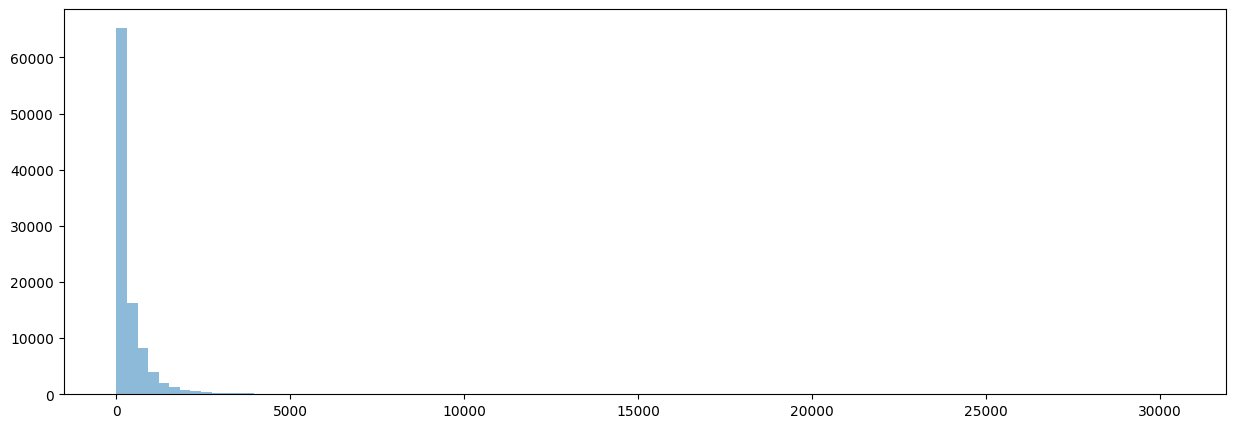

In [110]:
plt.figure(figsize=(15, 5))
plt.hist(sigma_posterior[0], bins=100, alpha=0.5, label="Posterior");

In [111]:
def get_mode(x):
    hist, bin_edges = np.histogram(x, bins=int(np.sqrt(len(x))))
    max_index = np.argmax(hist)
    mode = (bin_edges[max_index] + bin_edges[max_index+1])/2
    return mode

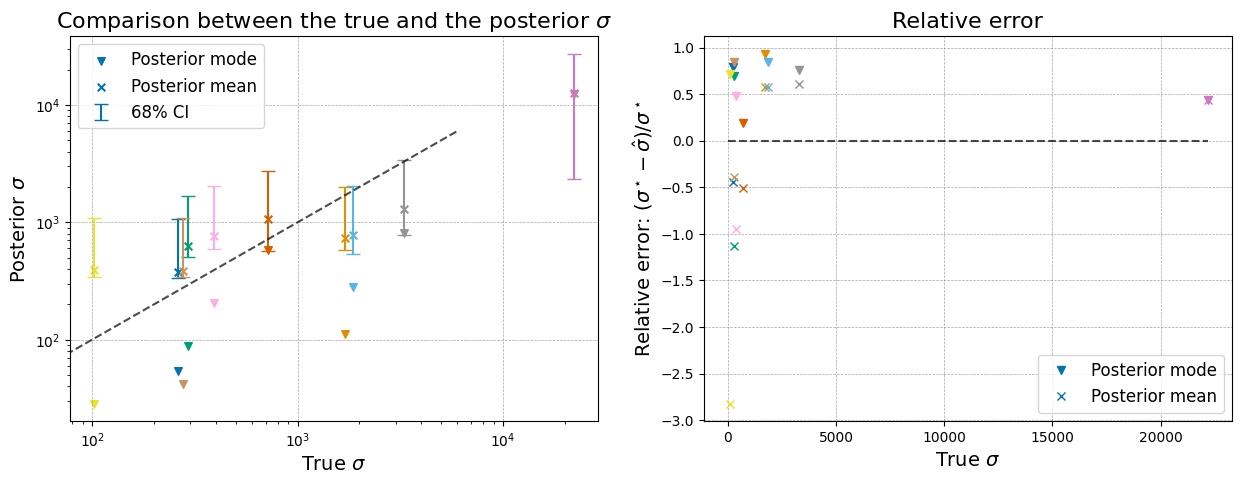

In [112]:
plt.figure(figsize=(15, 5))
colors = sns.color_palette("colorblind", n_colors=len(sigma_true))

plt.subplot(121)
for i in range(len(sigma_true)):
    mode = get_mode(sigma_posterior[i])
    mean = np.mean(sigma_posterior[i])
    cl = get_credibility_interval(sigma_posterior[i], 0.68)
    if i == 0:
        plt.scatter(sigma_true[i], mode, label=f"Posterior mode", s=30, marker="v", color=colors[i])
        plt.scatter(sigma_true[i], mean, label=f"Posterior mean", s=30, marker="x", color=colors[i])
        plt.errorbar(sigma_true[i], mean, yerr=[[cl[0]], [cl[1]]], 
                     fmt=' ', label=f"68% CI", capsize=5, color=colors[i])
    else:
        plt.scatter(sigma_true[i], mode, s=30, marker="v", color=colors[i])
        plt.scatter(sigma_true[i], mean, s=30, marker="x", color=colors[i])
        plt.errorbar(sigma_true[i], mean, yerr=[[cl[0]], [cl[1]]], 
                     fmt=' ', capsize=5, color=colors[i])

#plt.xlim([-100, 6e3])
plt.xscale("log")
#plt.ylim([-100, 6e3])
plt.yscale("log")
plt.plot([0, 6e3], [0, 6e3], color='black', linestyle='--', alpha=0.7)  
plt.xlabel(r"True $\sigma$", fontsize=14)
plt.ylabel(r"Posterior $\sigma$", fontsize=14)
plt.title(r"Comparison between the true and the posterior $\sigma$", fontsize=16)
plt.legend(loc="upper left", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

plt.subplot(122)
plt.title("Relative error", fontsize=16)
plt.xlabel("True $\sigma$", fontsize=14)
plt.ylabel(r"Relative error: $(\sigma^\star - \hat{\sigma})/\sigma^\star$", fontsize=14)
for i in range(len(sigma_true)):
    mode = get_mode(sigma_posterior[i])
    mean = np.mean(sigma_posterior[i])
    if i == 0:
        plt.plot(sigma_true[i], (sigma_true[i] - mode)/sigma_true[i], 'v', label=f"Posterior mode", color=colors[i])
        plt.plot(sigma_true[i], (sigma_true[i] - mean)/sigma_true[i], 'x', label=f"Posterior mean", color=colors[i])
    else:
        plt.plot(sigma_true[i], (sigma_true[i] - mode)/sigma_true[i], 'v', color=colors[i])
        plt.plot(sigma_true[i], (sigma_true[i] - mean)/sigma_true[i], 'x', color=colors[i])

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
plt.hlines(y=0, xmin=0, xmax=np.max(sigma_true), color='black', linestyle='--', alpha=0.7)
plt.legend(loc="lower right", fontsize=12);

## Comparison between analytical and empirical sigma

In [24]:
%%time
# Compute the obtained entropy production priors, individually for each simulation
emp_sigma_from_prior = np.array([])
sigma_from_prior = np.array([])

n_sim = int(1e4)
n_batch = int(1e2)

# n_sim = int(1e2)
# n_batch = int(1e1)

print("Computing %d simulations in %d batches" % (n_batch*(n_sim//n_batch), n_sim//n_batch))
for i in tqdm(range(n_sim//n_batch)):
    # Simulate the dynamics
    theta, theta_torch = get_theta_from_prior(prior_limits, n_sim//n_batch)
    x_trace, y_trace, f_trace = Simulator_noGPU(dt, DeltaT, TotalT, theta)

    # Compute the empirical entropy production
    _, _, _, emp_sigma = ComputeEmpiricalEntropy(x_trace, y_trace, f_trace, theta, n_batch, DeltaT)
    emp_sigma_from_prior = np.concatenate((emp_sigma_from_prior, emp_sigma))

    # Compute the analytical entropy production
    sigma_vec, _ = ComputeTheoreticalEntropy(theta, n_batch)
    sigma_from_prior = np.concatenate((sigma_from_prior, np.squeeze(sigma_vec)))

    # Clear the memory (for safety)
    #del theta, theta_torch, prior_box, x_trace, f_trace, y_trace
    #del emp_sigma_vec, sigma_vec

Computing 10000 simulations in 100 batches


100%|██████████| 100/100 [3:12:20<00:00, 115.41s/it] 

CPU times: total: 3h 8min 15s
Wall time: 3h 12min 20s


In [58]:
import os

if not os.path.exists('data'):
    os.makedirs('data')
    
action = "save"

if action == "save":
    with open("data/sigma_from_prior.pkl", 'wb') as f:
        pickle.dump(sigma_from_prior, f)

    with open("data/emp_sigma_from_prior.pkl", 'wb') as f:
        pickle.dump(emp_sigma_from_prior, f)

    with open("data/theta.pkl", 'wb') as f:
        pickle.dump(theta, f)

if action == "load":
    with open("data/sigma_from_prior.pkl", 'rb') as f:
        sigma_from_prior = pickle.load(f)

    with open("data/emp_sigma_from_prior.pkl", 'rb') as f:
        emp_sigma_from_prior = pickle.load(f)

    with open("data/theta.pkl", 'rb') as f:
        theta = pickle.load(f)

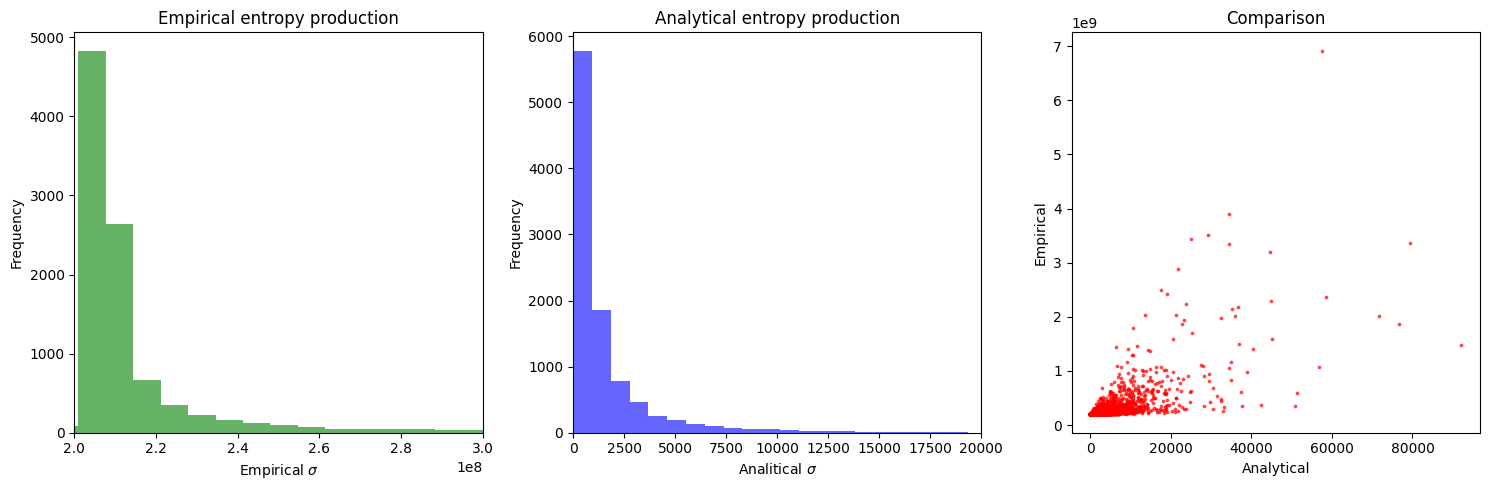

In [53]:
# do a figure with 3 subplots, 1 hist for empirical, 1 for analytical, 1 for the difference
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(emp_sigma_from_prior, bins=int(1e3),alpha=0.6, color='g')
ax[0].set_xlim(2e8, 0.3e9)
ax[0].set_title("Empirical entropy production")
ax[0].set_xlabel(r"Empirical $\sigma$")
ax[0].set_ylabel("Frequency")
ax[1].hist(sigma_from_prior, bins=int(np.sqrt(len(sigma_from_prior))),alpha=0.6, color='b')

ax[1].set_title("Analytical entropy production")
ax[1].set_xlabel(r"Analitical $\sigma$")
ax[1].set_ylabel("Frequency")
ax[1].set_xlim(0, 2e4)
ax[2].scatter(sigma_from_prior, emp_sigma_from_prior, alpha=0.6, color='r', s=3)
ax[2].set_title("Comparison")
ax[2].set_xlabel("Analytical")
ax[2].set_ylabel("Empirical")
plt.tight_layout()

